In [131]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from glob import glob
import json

In [137]:
project_root = os.path.join('..','..')
data_dir = os.path.join(project_root, "data", "vzf", "freestyle", "freestyle_1")

ann_list = glob(data_dir + "/ann/*")
im_list = glob(data_dir + "/img/*")



In [177]:
img_number = 1
with open(ann_list[img_number]) as json_file:
    ann = json.load(json_file)

print(ann.keys())
objects = ann['objects']
print(objects)
len(objects)
print(np.array([[1,2],[3,4]]))
print(np.array([obj['points']['exterior'] for obj in objects if obj['classTitle']=="Swimmer"]).flatten())

keypoint_list = []
for key_id in keypoints.keys():
    keypoint = [obj for obj in objects if obj['classTitle'].casefold()==keypoints[key_id].casefold()]
    coords = [kp['points']['exterior'] for kp in keypoint][0][0]
    visible = [0 if 'name' in obj.keys() and obj['name']=='invisible' else 1]
    if len(visible) > 1:
        print("Warning: image contains more than one instance of {}".format(keypoints[key_id]))
    print(keypoints[key_id])
    keypoint_list += [coords + visible]

print(keypoint_list)

dict_keys(['description', 'tags', 'size', 'objects'])
[]
[[1 2]
 [3 4]]
[]


IndexError: list index out of range

In [178]:
keypoints = {
    '0': "Head",
    '1': "Shoulder_Close",
    '2': "Elbow_Close",
    '3': "Wrist_Close",
    '4': "Hip_Close",
    '5': "Knee_Close",
    '6': "Ankle_Close",
    '7': "Shoulder_Far",
    '8': "Elbow_Far",
    '9': "Wrist_Far",
    '10': "Hip_Far",
    '11': "Knee_Far",
    '12': "Ankle_Far",

}

'''
Return target dict as described by 
https://github.com/pytorch/vision/blob/master/torchvision/models/detection/keypoint_rcnn.py
line 28-34
'''
def get_target_from_file(json_file):
    # parse json file to dict
    with open(json_file) as json_file:
        ann = json.load(json_file)
    
    # get annotated objects (discard some irrelevent image description and tags)
    objects = ann['objects']

    # init empty dict
    target = {}
    # List containing all person bounding boxes
    # flatten to array [x1 y1 x2 y2]
    target['boxes'] = np.array([obj['points']['exterior'] for obj in objects if obj['classTitle']=="Swimmer"]).flatten()

    # For each box in boxes add a label person
    target['labels'] = np.array(["person" for box in target['boxes']])

    keypoint_list = []
    for key_id in keypoints.keys():
        # for each keypoint specified in keypoints
        # find coordinates and visibility flag
        keypoint = [obj for obj in objects if obj['classTitle'].casefold()==keypoints[key_id].casefold()]
        coords = [kp['points']['exterior'] for kp in keypoint][0][0]
        visible = [0 if 'name' in obj.keys() and obj['name']=='invisible' else 1]

        # there should at most be 1 keypoint of a kind
        if len(visible) > 1:
            print("Warning: image contains more than one instance of {}".format(keypoints[key_id]))
            coords = coords[0:2]
            visible = visible[0]

        # add to the list
        keypoint_list += [coords + visible]
    
    # TODO extend this to multiple boxes when we start doing multi person labeling
    target['keypoints'] = keypoint_list
    
    return target



In [140]:
def draw_keypoints(image, keypoints):
    '''
    Display image with keypoints and bounding box
    '''
    image = io.imread(image)
    # create figure
    plt.figure()
    # show image
    plt.imshow(image)

    # add keypoints to image
    plt.scatter(np.array(keypoints)[:,0],np.array(keypoiynts)[:,1], s=10, marker='.', c='r')\
    # TODO: add color coding for different body parts
    
    # pause a bit so that plots are updated
    plt.pause(0.001)  
    
    # display
    plt.show()



In [141]:
target = get_target_from_file(ann_list[0])
draw_keypoints(im_list[0], target['keypoints'])


NameError: name 'keypoiynts' is not defined

In [222]:
class PoseDataset(Dataset):

    def __init__(self, dataset_list, stride, transform=None):
        '''
        dataset_list = contains all relevant datasets with subfolders ann and img as produced by supervise.ly
        stride = how densely the images are annotated, one every stride is annotated
        '''

        # keypoints of the dataset
        self.keypoints = {
            '0': "Head",
            '1': "Shoulder_Close",
            '2': "Elbow_Close",
            '3': "Wrist_Close",
            '4': "Hip_Close",
            '5': "Knee_Close",
            '6': "Ankle_Close",
            '7': "Shoulder_Far",
            '8': "Elbow_Far",
            '9': "Wrist_Far",
            '10': "Hip_Far",
            '11': "Knee_Far",
            '12': "Ankle_Far",
        }

        # list with connected joints in skeleton
        self.skeleton = [[1,2], [2,3], [1,4], [4,5], [5,6], [1,7], [7,8], [8,9], [7,10], [10,11], [11,12], [4,10]]

        self.stride = stride

        # only add annotated frames 
        ann_list = []
        for dataset in dataset_list:
            for ann_file in glob(os.path.join(dataset, "ann", '*')):
                if PoseDataset.is_annotated(ann_file):
                    ann_list += [ann_file]
        self.ann_list = ann_list

    def __len__(self):
        return len(self.ann_list)
    
    @staticmethod
    def is_annotated(ann_file):
        with open(ann_file) as file:
            ann = json.load(file)
            return len(ann['objects']) > 0
    
    @staticmethod
    def get_img_name_from_ann(ann_file):
        # change superdirectory form ann to img
        ann_file = ann_file.replace("ann", "img")

        # delete .json extension
        return ann_file.split('.json')[0]

    '''
    Return target dict as described by 
    https://github.com/pytorch/vision/blob/master/torchvision/models/detection/keypoint_rcnn.py
    line 28-34
    '''
    def get_target_from_file(self, json_file):
        # parse json file to dict
        with open(json_file) as json_file:
            ann = json.load(json_file)
        
        # get annotated objects (discard some irrelevent image description and tags)
        objects = ann['objects']

        # init empty dict
        target = {}
        # List containing all person bounding boxes
        # flatten to array [x1 y1 x2 y2]
        target['boxes'] = np.array([obj['points']['exterior'] for obj in objects if obj['classTitle']=="Swimmer"]).flatten()

        # For each box in boxes add a label person
        target['labels'] = np.array(["person" for box in target['boxes']])

        keypoint_list = []
        for key_id in self.keypoints.keys():
            # for each keypoint specified in keypoints
            # find coordinates and visibility flag
            keypoint = [obj for obj in objects if obj['classTitle'].casefold()==self.keypoints[key_id].casefold()]
            coords = [kp['points']['exterior'] for kp in keypoint][0][0]
            visible = [0 if 'name' in obj.keys() and obj['name']=='invisible' else 1]

            # there should at most be 1 keypoint of a kind
            if len(visible) > 1:
                print("Warning: image contains more than one instance of {}".format(keypoints[key_id]))
                coords = coords[0:2]
                visible = visible[0]

            # add to the list
            keypoint_list += [coords + visible]
        
        # TODO extend this to multiple boxes when we start doing multi person labeling
        target['keypoints'] = keypoint_list
        
        return target

    def draw_keypoints(self, idx):
        item = self[idx]
        PoseDataset.draw_keypoints_static(item['image'], item['target']['keypoints'], self.skeleton)

    @staticmethod
    def draw_keypoints_static(image, keypoints, skeleton=[]):
        '''
        Display image with keypoints and bounding box
        '''
        plt.figure()
        # show image
        plt.imshow(image)

        # add keypoints to image
        plt.scatter(np.array(keypoints)[:,0],np.array(keypoints)[:,1], s=10, marker='.', c='r')\
        # TODO: add color coding for different body parts
        
        # draw lines as specified in skeleton 
        if skeleton:
            for pair in skeleton:
                plt.plot([keypoints[pair[0]][0], keypoints[pair[1]][0]], [keypoints[pair[0]][1], keypoints[pair[1]][1]])

        # pause a bit so that plots are updated
        plt.pause(0.001)  
        
        # display
        plt.show()

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()

        # get relevant file paths
        ann_file = self.ann_list[idx]
        img_file = PoseDataset.get_img_name_from_ann(ann_file)

        # load image
        image = io.imread(img_file)

        # get target dict
        target = self.get_target_from_file(ann_file)

        return {'image': image,
                'target': target
        }

In [225]:
dataset = PoseDataset(['../../data/vzf/freestyle/freestyle_1'], 3)


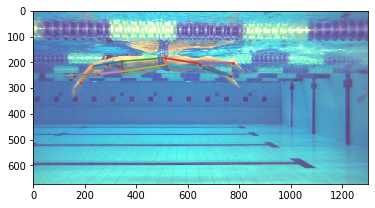

In [233]:
dataset.draw_keypoints(5)